In [1]:
import numpy as np
import tensorflow as tf
import time
import itertools
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import truncexpon, poisson, norm
from utils import *
from gen_inputs import *
from functs_inputs import *
from sim_hLN import *
from train_hLN import *
from init_hLN import *

matplotlib.rcParams["savefig.dpi"] = 200
matplotlib.rcParams["legend.frameon"] = False

## Now begin training of complex models, attempting to produce figure similar to S2 in Ujfalussy paper


### First step is to define a hierarchical clustering for the inputs - then they can be distributed correctly according to each hLN architecture


In [2]:
# list of lists for this maybe? e.g. the following:
clusts = [[[[[0, 1],[2]],[[3, 4],[5, 6]]],[[[7, 8],[9]],[[10, 11],[12]]]]]

In [3]:
### Define the different hLN architectures we will be using:

# 1L
Jc_1l = np.array([0])
# 1N
Jc_1n = np.array([0])
# 2N
Jc_2n = np.array([0, 1, 1])
# 3N
Jc_3n = np.array([0, 1, 1, 2, 2, 3, 3])
# 4N
Jc_4n = np.array([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

In [4]:
# Get some realistic inputs
X_tot = tf.convert_to_tensor(np.load('real_inputs.npy'), dtype=tf.float32)  # real inputs made earlier
X_e = X_tot[:629] # 629 excitatory inputs, in 13 ensembles
X_i = X_tot[629:] # 120 inhibitory inputs, also in 13 ensembles
# remember 1st inhibitory inputs is the somatic input - must always go to root subunit
# n_timepoints = 1000
# start = 100
inputs = X_tot

In [5]:
# Split the data into training and test sets, 80/20 initially
split=0.8
L = inputs.shape[1]
n_train = int(L * split)
train_inputs = inputs[:, :n_train]
test_inputs = inputs[:, n_train:]
print(train_inputs.shape, test_inputs.shape)

(749, 38400) (749, 9600)


In [58]:
# # just do single unit now for demonstration
# Wce_1l = [np.arange(0, n_e, 1)] #all input excitatory neurons connected to root subunit
# Wci_1l = [np.arange(n_e, n_e + n_i, 1)] #all input inhibitory neurons connected to root subunit

# Wce_2n, Wci_2n = create_weights(Jc_2n, n_levels=2, clusts=clusts)
# Wce_3n, Wci_3n = create_weights(Jc_3n, n_levels=3, clusts=clusts)
# Wce_4n, Wci_4n = create_weights(Jc_4n, n_levels=4, clusts=clusts)

We, Wi = create_weights(Jc_2n, n_levels=2, clusts=clusts)
print(Wi)

[ 48 106 158 192 237 276 320 388 438 500 530 590 629] [ 11  22  31  37  45  50  58  70  81  94 100 111 119]
[array([629.]), array([630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642,
       643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655,
       656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668,
       669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681,
       682, 683, 684, 685, 686, 687]), array([688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700,
       701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713,
       714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726,
       727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739,
       740, 741, 742, 743, 744, 745, 746, 747, 748])]


In [7]:
# initialise a known version each of the models to generate data with
hln_1l = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))

hln_1n = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))

hln_2n = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True]*len(Jc_2n)))

hln_3n = hLN_Model(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True]*len(Jc_3n)))

hln_4n = hLN_Model(Jc=Jc_4n, Wce=Wce_4n, Wci=Wci_4n, sig_on=tf.constant([True]*len(Jc_4n)))


In [8]:
# generate output data from realistic inputs - save this somewhere
# target_1l = hln_1l(inputs)
target_1l = tf.convert_to_tensor(np.load('target.npy'), dtype=tf.float32)  # real output made earlier
# np.save("target.npy", target_1l.numpy())

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(749, 38400), dtype=float32)


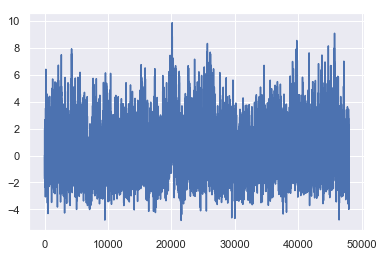

In [9]:
# pick one target to train all models for
plt.plot(target_1l.numpy())
train_target = target_1l[:n_train]
test_target = target_1l[n_train:]
plt.show()

In [10]:
# change parameters from ground truth
# probably want to create a new model here in order to preserve parameter information
hln_1l.randomise_parameters() 

In [11]:
# initialise 1L model, and optimise for data
# define optimizer
optimizer_1l = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.1)
# train model conventionally
# loss_values, accuracies = train(model=hln_1l, num_epochs=5, optimizer=optimizer_1l, inputs=train_inputs[:, :100], target=train_target[:100])
# train model with SGD
loss_values, accuracies = train_sgd(model=hln_1l, num_epochs=10000, optimizer=optimizer_1l, inputs=train_inputs, target=train_target)
# for continued training

100%|██████████| 10000/10000 [4:42:37<00:00,  1.67s/it] 


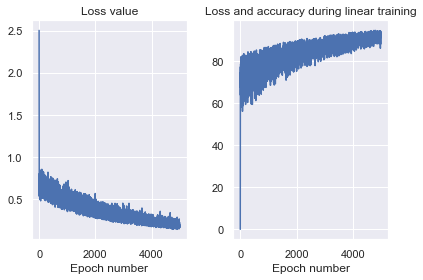

In [12]:
# visualise results from 1L training
plt.figure(1)

plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Loss value')
plt.xlabel('Epoch number')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Prediction accuracy (%)')
plt.xlabel('Epoch number')

plt.title('Loss and accuracy during linear training')
plt.tight_layout()

# output = hln_1l(inputs[:10000])

# plt.figure(2)
# plt.plot(target_1l.numpy(), label='Target signal')
# plt.plot(output.numpy(), label='Linear model after training')
# # plt.plot(first_output.numpy(), label='Model before training')
# plt.xlabel('Time (s)')
# # plt.ylabel('Membrane potential (arbitrary units)')
# plt.title('Membrane potential (in arbitrary \n units) over time')
# plt.legend()
plt.show()

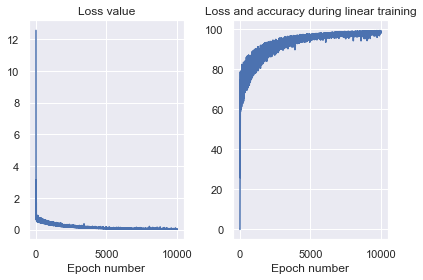

In [20]:
### CREATE PLOTTING FILE FOR STORING FUNCTIONS LIKE THIS
# visualise results from 1L training
plt.figure(1)

plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Loss value')
plt.xlabel('Epoch number')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Prediction accuracy (%)')
plt.xlabel('Epoch number')

plt.title('Loss and accuracy during linear training')
plt.tight_layout()

# output = hln_1l(inputs[:10000])

# plt.figure(2)
# plt.plot(target_1l.numpy(), label='Target signal')
# plt.plot(output.numpy(), label='Linear model after training')
# # plt.plot(first_output.numpy(), label='Model before training')
# plt.xlabel('Time (s)')
# # plt.ylabel('Membrane potential (arbitrary units)')
# plt.title('Membrane potential (in arbitrary \n units) over time')
# plt.legend()
# plt.savefig("linear_sgd_training.png")
plt.show()

In [45]:
# examine performance on test data
test_loss = loss(predicted_v=hln_1l(test_inputs), target_v=test_target)
test_accuracy = 100 * (1 - (test_loss/np.var(test_target)))
print("Final loss:", test_loss.numpy(), "Final accuracy:", test_accuracy.numpy())
print(hln_1l.Wwe)
print(hln_1l.params)

Final loss: 0.027821058 Final accuracy: 99.068054
<tf.Variable 'Variable:0' shape=(1, 629) dtype=float32, numpy=
array([[1.2160784 , 0.8161527 , 1.2391814 , 1.1566163 , 1.211909  ,
        0.913054  , 1.1571147 , 0.90904945, 1.261089  , 1.0841757 ,
        1.1921945 , 1.3299551 , 1.1907414 , 1.0344921 , 0.95844626,
        1.3625195 , 0.94355667, 0.90684   , 1.1007323 , 1.2775842 ,
        0.87675047, 0.7538753 , 1.08726   , 1.3127333 , 0.90832746,
        0.78575796, 1.1539341 , 1.2772746 , 0.9140707 , 1.4557784 ,
        1.0750067 , 0.970798  , 1.1879019 , 1.1989696 , 1.1542519 ,
        1.0845914 , 1.2406181 , 0.93275905, 1.2067127 , 0.9376274 ,
        1.1937048 , 0.80156916, 1.2215035 , 1.1592866 , 1.1227244 ,
        1.4949989 , 1.2563218 , 1.3745625 , 0.7758017 , 1.3506528 ,
        0.89828146, 1.0876143 , 1.2062341 , 1.3565657 , 0.8924994 ,
        1.1203284 , 0.92351145, 1.3060906 , 0.834596  , 1.2180716 ,
        1.232144  , 1.1948845 , 1.3520148 , 1.0526676 , 1.091527  ,
   

In [60]:
print(np.sum(hln_1l.Wwe.numpy())/629 + np.sum(hln_1l.Wwi.numpy())/120)

-0.10788444494784155


In [59]:
# initialise 1N model, optimise
hln_1n = hLN_Model(Jc=Jc_sing, Wci=Wci_sing, Wce=Wce_sing, sig_on=tf.constant([True]))
# set parameters to those of the linear model
# need to make sure new parameters are set to a COPY of old parameters to preserve the model
hln_1n.params, hln_1n.trainable_params = hln_1l.params.copy(), hln_1l.trainable_params.copy()


AttributeError: 'tuple' object has no attribute 'copy'

In [ ]:
### create whole new function for process in this cell 
# initialise 2N model, optimise

# first add the new leaves, linear settings at first
hln_2l = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, False, False])

# redistribute the inputs to the new leaves according to the hierarchical clustering

# now initalise the nonlinearities to approximate linear integration as before - init will need adjustment
hln_2n = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True])

# then optimise


In [ ]:
# initialise 3N model, optimise

In [ ]:
# initialise 4N model, optimise 

In [ ]:
# compare results